## Modelling the sea using grid-based methods

In [ ]:
!pip install basemap
!pip install basemap-data-hires

In [1]:
from pygradu import gridify
import shapely.geometry
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

import math

In [2]:
base_lat = [33, 42]
base_lon = [122, 132]

# 탱커와 벌커의 평균 속도: 15~16노트(28~30km/h)
avg_speed = 30
pivot_time = 5
gridmap_pivot_distance_km = 5

earth_radius = 6371
lat_distance_per_one = round(earth_radius * math.pi / 180, 3)
lon_distance_per_one = {0:111.322, 5:110.902, 10:109.643, 15:117.553, 20:114.650, 25:100.953, 30:96.490, 
                        35:91.290, 40:85.397, 45:78.850, 50:71.700, 55:63.997, 60:55.803, 65:47.178, 70:38.188, 
                        75:28.904, 80:19.394, 85:9.735, 90:0}

absolute_distance_pos = [[0],[0]]

for lat in range(base_lat[0]+1, base_lat[1]+1):
    absolute_distance_pos[0].append(lat_distance_per_one)
    absolute_distance_pos[1].append(lon_distance_per_one[(lat//5)*5])

In [3]:
absolute_distance_pos

[[0,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195,
  111.195],
 [0, 96.49, 91.29, 91.29, 91.29, 91.29, 91.29, 85.397, 85.397, 85.397]]

In [4]:
grid_lat = [base_lat[0]]
grid_lon = [base_lon[0]]

for ilat in range(1, len(absolute_distance_pos[0])):
    vlat = lat_distance_per_one # this is never changed. so not need
    while(True):
        tlat = 0
        if(tlat != gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km - tlat
        elif(vlat > gridmap_pivot_distance_km): tlat = gridmap_pivot_distance_km
        else: tlat = vlat # vlat <= gridmap_pivot_distance_km

        vlat -= tlat
        dlat = tlat/lat_distance_per_one

        grid_lat.append(grid_lat[-1] + dlat)

        if(vlat <= 0):
            break

collection_grid_lat = [(grid_lat[i]-base_lat[0])*(base_lat[1]-grid_lat[-1])/(grid_lat[-1]-base_lat[0]) for i in range(0, len(grid_lat))]
grid_lat = [x+y for x,y in zip(grid_lat, collection_grid_lat)]

for ilon in range(1, len(absolute_distance_pos[1])):
    vlon = absolute_distance_pos[1][ilon]
    while(True):
        tlon = 0
        if(tlon != gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km - tlon
        elif(vlon > gridmap_pivot_distance_km): tlon = gridmap_pivot_distance_km
        else: tlon = vlon # vlon <= gridmap_pivot_distance_km
            
        vlon -= tlon
        dlon = tlon/lon_distance_per_one[(ilon//5)*5]
            
        grid_lon.append(grid_lon[-1] + dlon)
            
        if(vlon <= 0):
            break

collection_grid_lon = [(grid_lon[i]-base_lon[0])*(base_lon[1]-grid_lon[-1])/(grid_lon[-1]-base_lon[0]) for i in range(0, len(grid_lon))]
grid_lon = [x+y for x,y in zip(grid_lon, collection_grid_lon)]
        
print('Grid_latitude')
print(grid_lat)
print()
print('Grid_longitude')
print(grid_lon)

Grid_latitude
[33.0, 33.04347826086956, 33.08695652173913, 33.130434782608695, 33.17391304347826, 33.21739130434783, 33.26086956521739, 33.30434782608695, 33.34782608695652, 33.391304347826086, 33.43478260869565, 33.47826086956522, 33.52173913043478, 33.56521739130435, 33.608695652173914, 33.65217391304348, 33.69565217391305, 33.73913043478261, 33.78260869565217, 33.82608695652174, 33.869565217391305, 33.91304347826087, 33.95652173913044, 34.0, 34.04347826086956, 34.08695652173913, 34.130434782608695, 34.17391304347826, 34.21739130434783, 34.26086956521739, 34.30434782608695, 34.34782608695652, 34.391304347826086, 34.43478260869565, 34.47826086956522, 34.52173913043478, 34.56521739130435, 34.608695652173914, 34.65217391304348, 34.69565217391305, 34.73913043478261, 34.78260869565217, 34.82608695652174, 34.869565217391305, 34.91304347826087, 34.95652173913044, 35.0, 35.04347826086956, 35.08695652173913, 35.130434782608695, 35.17391304347826, 35.21739130434783, 35.26086956521739, 35.30434

In [5]:
def draw_basemap_grid(lats, lons, m):
    x, y = m(lons, lats)
    xy = zip(x, y)
    poly = Polygon(list(xy), facecolor="none", edgecolor='black', lw=0.7, alpha=0.4)
    plt.gca().add_patch(poly)
    return poly

In [6]:
DATA_DIR = "data/AIS/"
skiprow_count = 2

f = open(DATA_DIR+'Dynamic_20200203.csv', 'r', encoding='cp949')
for i in range(0, skiprow_count):
    line = f.readline()
    if not line: break
    print(line)
f.close()

ais = pd.read_csv(DATA_DIR+'Dynamic_20200203.csv',
                  encoding='cp949', sep='\s+|,', engine='python', 
                  skiprows=range(0, skiprow_count),
                  names=['MMSI','일자', '시간', '위도','경도', 'SOG', 'COG', 'Heading'])
print('len AIS:' + str(len(ais)))

조회 기간 : 2020-02-03 00:00:00 ~ 2020-02-03 23:59:59

조회선박 척수 : 7638

len AIS:20418468


In [7]:
ais

,MMSI,일자,시간,위도,경도,SOG,COG,Heading
0,MMSI,일시,위도,경도,SOG,COG,Heading,NaN
1,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:06,33.957865,126.673896666667,5.3,272.2,278.0
2,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:16,33.9578716666667,126.67359,5.5,271.3,278.0
3,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:27,33.95788,126.673286666667,5.3,272,279.0
4,rjFyyVyimurB7BM2WdKWWQ==,2020-02-03,00:00:36,33.957895,126.672983333333,5.4,273.6,281.0
...,...,...,...,...,...,...,...,...
20418463,f6trMpkAwYR37AuCx/LNbw==,2020-02-03,23:58:28,91,181,102.3,360,511.0
20418464,f6trMpkAwYR37AuCx/LNbw==,2020-02-03,23:59:09,91,181,102.3,360,511.0
20418465,f6trMpkAwYR37AuCx/LNbw==,2020-02-03,23:59:17,91,181,102.3,360,511.0
20418466,f6trMpkAwYR37AuCx/LNbw==,2020-02-03,23:59:28,91,181,102.3,360,511.0


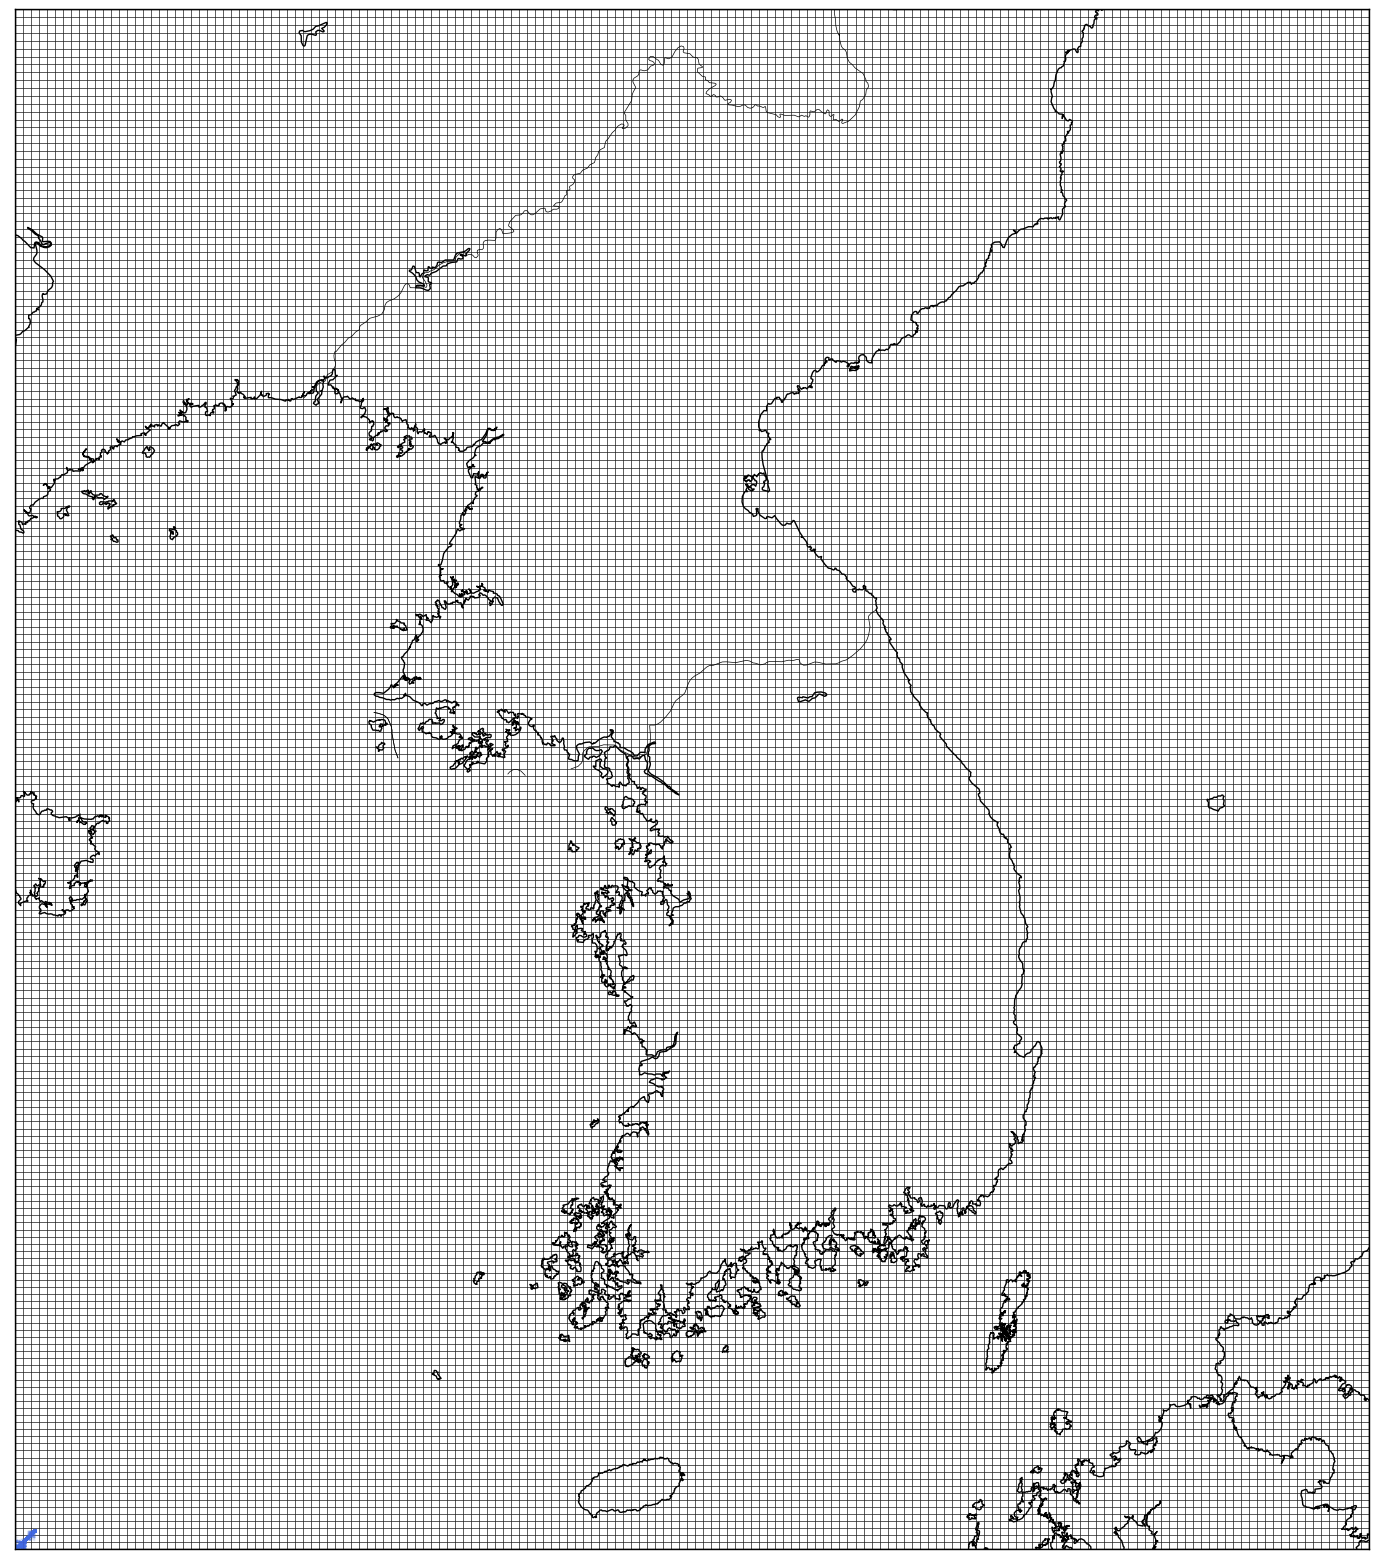

In [20]:
f = plt.figure(figsize=[20,20])
m = Basemap(llcrnrlon = base_lon[0], llcrnrlat = base_lat[0], 
            urcrnrlon = base_lon[1], urcrnrlat = base_lat[1],
            resolution='h', projection='merc',)
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary()
m.shadedrelief()

grid_map = {}
for ilon in range(1, len(grid_lon)):
    for ilat in range(1, len(grid_lat)):
        lats = [grid_lat[ilat-1], grid_lat[ilat], grid_lat[ilat], grid_lat[ilat-1]]
        lons = [grid_lon[ilon-1], grid_lon[ilon-1], grid_lon[ilon], grid_lon[ilon]]
        p = draw_basemap_grid(lats, lons, m)
        key = '(%d,%d)'%(ilon-1, ilat-1)
        grid_map[key] = p

xy = ais
plt.plot(xy.경도, xy.위도, 'o', c='royalblue', alpha=0.1, markersize=0.5)
plt.show()